# GMM Model Training

Use save.pkl data from simulator to train DP-GMM model with sk-learn. Scikit-learn documentation for GMMs [here](http://scikit-learn.org/stable/modules/mixture.html).

In [2]:
%matplotlib notebook
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import mat4py
import math

In [3]:
mpl.style.use('mitch-exp')

### Load data from 'save.pkl'

There is an issue where single button pushes trigger multiple record events. So we will load data and collapse identical and consecutive trials. 

In [6]:
with open('save_old.pkl', 'rb') as savefile:
    demo_sgs = np.array(pickle.load(savefile))

demo_sgs

array([[  7.        ,   2.29190757,   4.        ,   0.3       ],
       [  7.        ,   0.65908874,   4.        ,   1.2       ],
       [  7.        ,   0.65908874,   4.        ,   1.2       ],
       [  7.        ,   0.65908874,   4.        ,   1.2       ],
       [  5.46870482,   0.65908874,   4.        ,   1.2       ],
       [  5.46870482,   0.65908874,   4.        ,   1.2       ],
       [  7.02735226,   8.65787906,   9.41274178,   1.2       ],
       [  7.02735226,   8.65787906,   9.41274178,   1.2       ],
       [  9.93321506,   8.65787906,  10.21799804,   1.2       ],
       [  9.93321506,   8.65787906,  10.21799804,   1.2       ],
       [  8.10639974,   5.34723164,  10.21799804,   0.3       ],
       [  8.10639974,   5.34723164,   4.30786354,   0.3       ],
       [  8.10639974,   5.34723164,   4.30786354,   0.3       ],
       [  8.10639974,   5.34723164,   4.30786354,   0.3       ],
       [  8.10639974,   5.34723164,   4.30786354,   0.3       ],
       [  8.10639974,   2

In [7]:
demo_shift = np.insert(demo_sgs[1:], -1, [0, 0, 0, 0], axis=0)
demo_shift.shape

(76, 4)

In [8]:
demo_collapse = demo_sgs[(demo_shift != demo_sgs).any(axis=-1)]
demo_collapse.shape

(31, 4)

In [29]:
np.random.rand(1, 3)

array([[ 0.06065869,  0.76239378,  0.04272853]])

In [38]:
noise = np.hstack((np.zeros((31, 3)), np.random.randn(31, 1)/20))
demo_collapse += noise

In [39]:
def forward_kin_v(exc, sw, bm, sk, bk, bias=0):
    '''This func is the same as 'forward_kin' in this module but is easily vectorized.

    Note: ported to Python from MATLAB "fwd_kin.m", assumed options = [0, 0]

    Args:
        exc (dict): a dict of the excavator physical parameters
        sw (float): the swing angle
        bm (float): boom displacement in cm
        sk      ^^
        bk      ^^
        bias (float): positive z bias on output, to adjust weird base frame

    Returns:
        eef (list: float): the position of the end-effector (EEF) in (x, y, z - base frame) and the angle of the bucket (axis x4 w.r.t. x1(0?) ground axis)
    '''
    # Assign the base swing angle
    t1 = sw

    # Define lengths
    a1 = exc['a1']
    a2 = exc['a2']
    a3 = exc['a3']
    a4 = exc['a4']

    # Compute or Get joint angles
    # Boom angle
    r_c1 = bm + exc['r_cyl1']
    a_a1b = np.arccos((exc['r_o1b']**2 + exc['r_o1a']**2 - r_c1**2)/(2 * exc['r_o1b']*exc['r_o1a']))
    t2 = a_a1b - exc['a_b12'] - exc['a_a1x1']

    # Stick angle
    r_c2 = sk + exc['r_cyl2']
    a_c2d = np.arccos((exc['r_o2c']**2 + exc['r_o2d']**2 - r_c2**2)/(2 * exc['r_o2c'] * exc['r_o2d']))
    t3 = 3 * np.pi - exc['a_12c'] - a_c2d - exc['a_d23']

    # Bucket angle
    r_c3 = bk + exc['r_cyl3']
    a_efh = np.arccos((exc['r_ef']**2 + exc['r_fh']**2 - r_c3**2)/(2 * exc['r_ef'] * exc['r_fh']))
    a_hf3 = np.pi - exc['a_dfe'] - a_efh
    r_o3h = math.sqrt(exc['r_o3f']**2 + exc['r_fh']**2 - 2 * exc['r_o3f'] * exc['r_fh'] * np.cos(a_hf3))
    a_f3h = np.arccos((r_o3h**2 + exc['r_o3f']**2 - exc['r_fh']**2)/(2 * r_o3h * exc['r_o3f']))
    a_h3g = np.arccos((r_o3h**2 + exc['r_o3g']**2 - exc['r_gh']**2)/(2 * r_o3h * exc['r_o3g']))
    t4 = 3 * np.pi - a_f3h - a_h3g - exc['a_g34'] - exc['a_23d']

    c1 = np.cos(t1)
    c2 = np.cos(t2)
    c234 = np.cos(t2 + t3 + t4)
    c23 = np.cos(t2 + t3)
    s1 = np.sin(t1)
    s2 = np.sin(t2)
    s234 = np.sin(t2 + t3 + t4)
    s23 = np.sin(t2 + t3)

    P04 = np.array([[c1*(a4*c234+a3*c23+a2*c2+a1)],
                    [s1*(a4*c234+a3*c23+a2*c2+a1)],
                    [(a4*s234+a3*s23+a2*s2)],
                    [1]])

    # Bucket angle; angle between x4 and x0-y0 plane
    tb = t2 + t3 + t4 - 3 * np.pi

    # Position and orientation of the end effector
    eef = [axis.pop() for axis in P04[0:3].tolist()]
    assert eef
    eef.append(tb)

    return eef[0], eef[1], eef[2] + bias

In [40]:
forward_kin = np.vectorize(forward_kin_v)
exc = mat4py.loadmat('exc.mat')['exc']

In [41]:
demo_xyz = np.array(forward_kin(exc, demo_collapse[:, 3], demo_collapse[:, 0],
                      demo_collapse[:, 1], demo_collapse[:, 2], bias=17.1))
demo_xyz.shape

(3, 31)

In [42]:
demo_xyz[2]

array([ 11.72434224,  20.00441254,   4.04374659,   8.08167226,
        29.78968294,  19.65106349,  11.82043957,  22.38967752,
         6.62006053,  10.90792383,  31.25891978,  24.79399465,
        18.23243413,  26.50582173,   0.20549216,  -5.82748465,
        23.47763987,  19.99578152,  26.42307338,  32.8445548 ,
         4.0701923 ,   1.7254467 ,  32.46977497,  28.88664948,
        22.24213047,  24.32407024,   3.94692101,   2.52529324,
        35.48435939,  28.11167017,  20.19511114])

In [43]:
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn import mixture

<IPython.core.display.Javascript object>


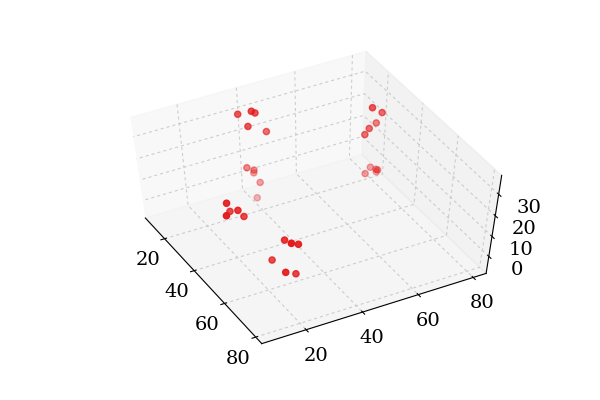

In [44]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(demo_xyz[0], demo_xyz[1], demo_xyz[2], zdir='z')

In [45]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r'])

def plot_results(X, Y_, title):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in range(6):
#         v, w = linalg.eigh(covar)
#         v = 2. * np.sqrt(2.) * np.sqrt(v)
#         u = w[0] / linalg.norm(w[0])
#         # as the DP will not use every component it has access to
#         # unless it needs it, we shouldn't plot the redundant
#         # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], X[Y_ == i, 2], zdir='z', c=color_iter.next())

#     plt.xlabel('X')
#     plt.ylabel('Y')
    plt.title(title)

In [46]:
demo_xyz.T.shape

(31, 3)

<IPython.core.display.Javascript object>


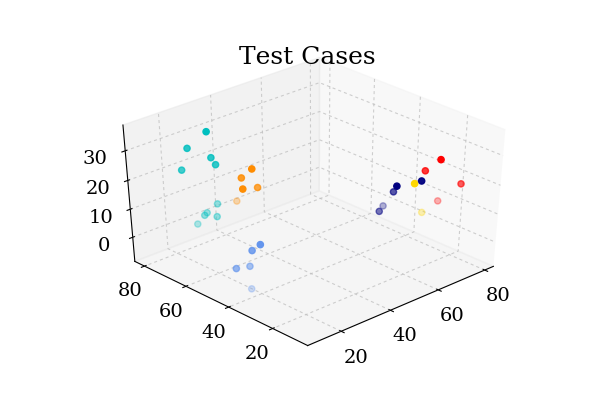

The 0'th subgoal distribution is located at [  8.46889584   5.15531025  10.40988988   0.28758998] with covariance [[ 0.06866814  0.05814384  0.01974632 -0.00404748]
 [ 0.05814384  1.73736228 -0.26705174  0.07085246]
 [ 0.01974632 -0.26705174  0.0594514  -0.01560135]
 [-0.00404748  0.07085246 -0.01560135  0.00457104]].
The 1'th subgoal distribution is located at [ 6.68162712  1.1235878   3.99624042  1.2096657 ] with covariance [[ 1.4630037   0.43043563  0.0908025  -0.00309146]
 [ 0.43043563  0.54607335  0.03676234 -0.0165066 ]
 [ 0.0908025   0.03676234  0.12396982 -0.00509445]
 [-0.00309146 -0.0165066  -0.00509445  0.00146597]].
The 2'th subgoal distribution is located at [ 6.1728366   8.12199849  9.47742238  1.19783531] with covariance [[ 0.76729717  0.70581813  0.07412056 -0.01295438]
 [ 0.70581813  0.7102314   0.05914164 -0.01567447]
 [ 0.07412056  0.05914164  0.03663437 -0.00410866]
 [-0.01295438 -0.01567447 -0.00410866  0.00278727]].
The 3'th subgoal distribution is located at [ 8.

In [50]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(demo_collapse)

plot_results(demo_xyz.T, gmm.predict(demo_collapse), 'Test Cases')

for i in range(6):
    print('The %i\'th subgoal distribution is located at %s with covariance %s.') % (i, gmm.means_[i], gmm.covariances_[i])

In [53]:
ind = range(6)
ind.pop(3)
gmm_model = {'means': gmm.means_[ind],
             'covs': gmm.covariances_[ind]}

with open('gmm_model.pkl', 'wb') as savefile:
    pickle.dump(gmm_model, savefile)

In [54]:
gmm_model.values()

[array([[[  6.86681382e-02,   5.81438450e-02,   1.97463238e-02,
           -4.04747605e-03],
         [  5.81438450e-02,   1.73736228e+00,  -2.67051737e-01,
            7.08524575e-02],
         [  1.97463238e-02,  -2.67051737e-01,   5.94513960e-02,
           -1.56013477e-02],
         [ -4.04747605e-03,   7.08524575e-02,  -1.56013477e-02,
            4.57103850e-03]],
 
        [[  1.46300370e+00,   4.30435631e-01,   9.08025012e-02,
           -3.09145668e-03],
         [  4.30435631e-01,   5.46073353e-01,   3.67623363e-02,
           -1.65066009e-02],
         [  9.08025012e-02,   3.67623363e-02,   1.23969819e-01,
           -5.09444861e-03],
         [ -3.09145668e-03,  -1.65066009e-02,  -5.09444861e-03,
            1.46596612e-03]],
 
        [[  7.67297172e-01,   7.05818129e-01,   7.41205612e-02,
           -1.29543849e-02],
         [  7.05818129e-01,   7.10231397e-01,   5.91416387e-02,
           -1.56744685e-02],
         [  7.41205612e-02,   5.91416387e-02,   3.66343700e-02,
